In [39]:
import numpy
import numpy as np
from mat4py import loadmat
import pandas as pd
from sklearn import tree, svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import plotly.express as px
import os
import graphviz
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [40]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

def scaler(X):
    X = (X-np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X

def data_prepare(return_total = True):
    data = loadmat('ML-R-MG.mat')
    data_training = data['trainingset_HTEonly']
    data_test = data['testset_HTEonly']
    data_liter = data['allset_Literature']
    data_training = np.asarray(data_training, dtype=np.float64)
    data_test = np.asarray(data_test, dtype=np.float64)
    data_liter = np.asarray(data_liter, dtype=np.float64)

    x_train = np.c_[data_training[:,1]*1000000,data_training[:,3],data_training[:,4],data_training[:,5],data_training[:,6]]
    x_test = np.c_[data_test[:,1]*1000000,data_test[:,3],data_test[:,4],data_test[:,5],data_test[:,6]]
    x_ind = np.c_[data_liter[:,1]*1000000,data_liter[:,3],data_liter[:,4],data_liter[:,5],data_liter[:,6]]
    y_train = data_training[:, 8]
    y_test = data_test[:, 8]
    y_ind = data_liter[:, 8]

    x_total = np.concatenate((x_test, x_train), axis=0)
    y_total = np.concatenate((y_test, y_train), axis=0)
    if return_total:
        return x_total, y_total, x_ind, y_ind
    else:
        return x_train, y_train, x_test, y_test

def k_fold_cross_validation(model, k, x_set, y_set, x_ind, y_ind, scaler = None, ann=False):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    model_train_score_list = []
    model_test_score_list = []
    model_ind_score_list = []
    model_coef_score_list = []

    if scaler == "MinMax":
        scaler = MinMaxScaler()
        scaler.fit(x_set)
        fed_x_set = scaler.transform(x_set)
        fed_x_ind = scaler.transform(x_ind)
    elif scaler == "Cheat":
        scaler = StandardScaler()
        x_total = np.concatenate((x_set, x_ind), axis=0)
        scaler.fit(x_total)
        fed_x_set = scaler.transform(x_set)
        fed_x_ind = scaler.transform(x_ind)
    else:
        fed_x_set = x_set
        fed_x_ind = x_ind

    for train_index, test_index in skf.split(fed_x_set, y_set):
        x_train, x_test = fed_x_set[train_index], fed_x_set[test_index]
        y_train, y_test = y_set[train_index], y_set[test_index]
        if ann:

            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
            mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

            model.fit(x_train, y_train, batch_size=20, epochs=1500, validation_data=(x_test, y_test), callbacks=[es, mc], verbose=0)
        else:
            model.fit(x_train, y_train)
        try:
            model_train_score_list.append(model.score(x_train, y_train))
            model_test_score_list.append(model.score(x_test, y_test))
            model_ind_score_list.append(model.score(fed_x_ind, y_ind))
        except:

            model_train_score_list.append(model.evaluate(x_train, y_train)[1])
            model_test_score_list.append(model.evaluate(x_test, y_test)[1])
            model_ind_score_list.append(model.evaluate(fed_x_ind, y_ind)[1])
        try:
            model_coef_score_list.append(model.coef_)
        except:
            model_coef_score_list.append([])
    sum_dict = {"Train_S": model_train_score_list, "Test_S": model_test_score_list, "Lit_S": model_ind_score_list, "Coef": model_coef_score_list}
    return pd.DataFrame(sum_dict)

def show_anal(df_model_result, name_model):
    print(name_model + ":")
    print(df_model_result[["Train_S", "Test_S", "Lit_S"]].describe())
    for i in list(df_model_result["Coef"]):
        if len(i) > 0:
            print(i)

def ANN():
    mdl = Sequential()

    mdl.add(Dense(50, input_dim=2, activation='relu'))
    mdl.add(Dense(1, activation='sigmoid'))
    mdl.compile(optimizer=Adam(lr=1e-2), loss="binary_crossentropy", metrics=['accuracy'])
    return mdl

def SVC():
    svc = svm.SVC(kernel="linear", C=1)
    return svc

In [41]:
x_total, y_total, x_ind, y_ind = data_prepare()
lrc = LogisticRegression()
df_lrc = k_fold_cross_validation(lrc,10, x_total, y_total, x_ind, y_ind, scaler = "MinMax")
tree_model = tree.DecisionTreeClassifier(max_depth=3)
df_tree = k_fold_cross_validation(tree_model,10, x_total, y_total, x_ind, y_ind)
ann = ANN()
df_ann = k_fold_cross_validation(ann,10, x_total[:,[0,1]], y_total, x_ind[:,[0,1]], y_ind, scaler =  "MinMax", ann= True) #"Cheat"
svc = SVC()
df_svc = k_fold_cross_validation(svc,10, x_total, y_total, x_ind, y_ind, scaler = "MinMax")

C:\Users\Jaeho\PycharmProjects\ML-Resistivity-MG\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1495: early stopping
13/13 [==============================] - 0s 667us/step - loss: 3.2859 - accuracy: 0.7118
Epoch 128: early stopping
13/13 [==============================] - 0s 667us/step - loss: 3.3364 - accuracy: 0.7020
Epoch 107: early stopping
13/13 [==============================] - 0s 583us/step - loss: 2.9244 - accuracy: 0.7660
Epoch 113: early stopping
13/13 [==============================] - 0s 665us/step - loss: 3.4801 - accuracy: 0.7192
Epoch 159: early stopping
13/13 [==============================] - 0s 666us/step - loss: 3.7479 - accuracy: 0.7241
Epoch 101: early stopping
13/13 [===========

In [42]:
show_anal(df_lrc,"logistic Regression")
show_anal(df_tree, "Tree 3")
show_anal(df_ann, "ANN")
show_anal(df_svc, "SVC")



logistic Regression:
         Train_S     Test_S      Lit_S
count  10.000000  10.000000  10.000000
mean    0.755695   0.754409   0.777833
std     0.009743   0.087123   0.006338
min     0.738007   0.666667   0.766010
25%     0.750692   0.675000   0.774631
50%     0.755515   0.733333   0.778325
75%     0.762868   0.818548   0.780788
max     0.768382   0.903226   0.788177
[[ 3.51473644  2.27880642 -1.4697552  -0.48458799 -0.97732186]]
[[ 3.4881081   2.4899658  -1.30692066 -0.43991786 -0.8364384 ]]
[[ 3.53200513  2.39874409 -1.46989553 -0.67045864 -1.05855151]]
[[ 3.65988472  2.37739193 -1.48126772 -0.65405768 -1.09163474]]
[[ 3.75851099  2.58205746 -1.35183917 -0.44504252 -1.1786336 ]]
[[ 3.41582451  2.63865762 -1.52531754 -0.65374401 -1.17324031]]
[[ 3.61332107  2.55882887 -1.35777644 -0.76466308 -1.20908932]]
[[ 3.50344187  2.4643061  -1.58268159 -0.29458715 -1.22994334]]
[[ 3.55913702  2.39618857 -1.52918412 -0.75208056 -1.15602501]]
[[ 3.71202417  2.47812279 -1.55891633 -0.52306816 -1

In [43]:
scaler = MinMaxScaler()
scaler.fit(x_total)
print(x_total)

x_train, y_train, x_test, y_test = data_prepare(return_total=False)

stan_x_train = scaler.transform(x_train)
stan_x_test = scaler.transform(x_test)
stan_x_ind = scaler.transform(x_ind)


[[  0.382        0.04351692  -9.62944119   1.88250804   0.0970372 ]
 [  1.99973      0.09370419 -32.3584721    1.57808438   0.24225934]
 [  2.29754      0.09531225 -15.96206155   1.61310764   0.24620587]
 ...
 [  2.02545      0.06047817 -17.63913076   1.61190348   0.0501985 ]
 [  2.06211      0.05852358 -19.3157887    1.60971817   0.04857609]
 [  2.0385       0.05377662 -22.21679522   1.60161978   0.04738627]]
0.756198347107438
0.75
0.7512315270935961


Linear Regression

In [54]:
lrc_real = LogisticRegression()
lrc_real.fit(stan_x_train, y_train)

print(lrc_real.score(stan_x_train, y_train))
print(lrc_real.score(stan_x_test, y_test))
print(lrc_real.score(stan_x_ind, y_ind))
df = pd.DataFrame()
coef = lrc_real.coef_[0]
color = ["red" if co > 0 else "blue" for co in coef]
df["Property"] = ["drho", "delta", "dHmix", "ENavg", "dEN"]
df["Coefficient"] = coef
df["Color"] = color
fig = px.bar(df, x= "Property", y="Coefficient", color = "Coefficient",  color_continuous_scale='Bluered_r')
fig.update_layout(plot_bgcolor="white")
fig.show()
print(coef)

0.756198347107438
0.75
0.7512315270935961
[ 3.385683    2.24709451 -1.52021153 -0.40338992 -0.85687107]


Tree Model

0.8264462809917356
0.7833333333333333
0.8472906403940886


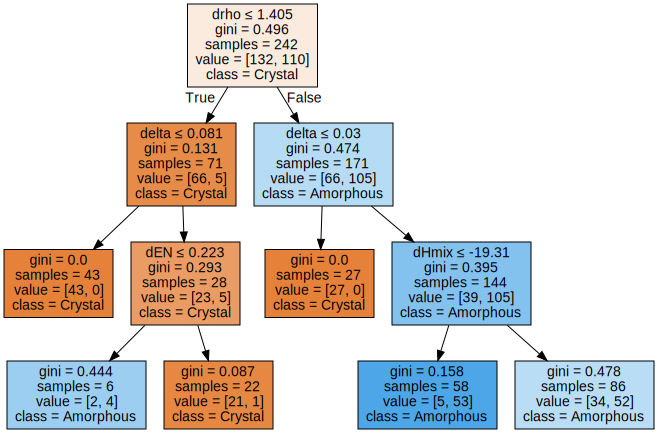

In [53]:
tree_real = tree.DecisionTreeClassifier(max_depth=3)
tree_real.fit(x_train, y_train)
print(tree_real.score(x_train, y_train))
print(tree_real.score(x_test, y_test))
print(tree_real.score(x_ind, y_ind))
dot_data3 = tree.export_graphviz(tree_real,   # 의사결정나무 모형 대입
                               out_file = None,  # file로 변환할 것인가
                               feature_names = ["drho", "delta", "dHmix", "ENavg", "dEN"],  # feature 이름
                               class_names = ["Crystal","Amorphous"],  # target 이름
                               filled = True,           # 그림에 색상을 넣을것인가
                               rounded = False,          # 반올림을 진행할 것인가
                               special_characters = True)   # 특수문자를 사용하나
graph3 = graphviz.Source(dot_data3)
graph3

In [55]:
svc_real = SVC()
svc_real.fit(stan_x_train, y_train)

print(svc_real.score(stan_x_train, y_train))
print(svc_real.score(stan_x_test, y_test))
print(svc_real.score(stan_x_ind, y_ind))
df = pd.DataFrame()
coef = svc_real.coef_[0]
color = ["red" if co > 0 else "blue" for co in coef]
df["Property"] = ["drho", "delta", "dHmix", "ENavg", "dEN"]
df["Coefficient"] = coef
df["Color"] = color
fig = px.bar(df, x= "Property", y="Coefficient", color = "Coefficient",  color_continuous_scale='Bluered_r')
fig.update_layout(plot_bgcolor="white")
fig.show()
print(coef)

0.7355371900826446
0.7666666666666667
0.8004926108374384
[ 3.04157917  2.7600585  -1.78938137 -0.31437271 -1.87673954]
